# 1 - Dataset Importation

Upload the 'kaggle.json' file (download it as a token from settings in your Kaggle profile)

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
#ls -a /root/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

!unzip  /content/breast-ultrasound-images-dataset.zip
# ls -la ./Dataset_BUSI_with_GT/benign
# ls -la ./Dataset_BUSI_with_GT/malignant
# ls -la ./Dataset_BUSI_with_GT/normal

Saving breast-ultrasound-images-dataset.zip to breast-ultrasound-images-dataset.zip
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 70, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1493, in dataset_download_cli
    self.dataset_download_files(dataset,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1447, in dataset_download_files
    self.download_file(response, outfile, quiet, not force)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1834, in download_file
    size = int(response.headers['Content-Length'])
  File "/usr/local/lib/python3.10/dist-packages/urllib3/_collections.py", line 258, in __getitem__
    val = self._container[ke

# 2 - Library Importation

In [3]:
import os
import random
import warnings
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import albumentations as alb
from PIL import Image
from pathlib import Path
from keras import Sequential
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory, plot_model
from keras.layers import (Input, Rescaling, Conv2D, Flatten,
                          Dense, Dropout, MaxPool2D, RandomFlip,
                          RandomRotation, RandomZoom, RandomContrast,
                          RandomBrightness, RandomCrop, Lambda)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, EarlyStopping
from tensorflow import keras
from tensorflow.keras.applications import vgg16, ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split

# 3 - Dataset Exploration

In [4]:
benign_files = os.listdir("/content/Dataset_BUSI_with_GT/benign")
malignant_files = os.listdir("/content/Dataset_BUSI_with_GT/malignant")
normal_files = os.listdir("/content/Dataset_BUSI_with_GT/normal")

In [5]:
# Explore the number of files in each folder (benign, malignant, normal)
print(f'In the Benign folder, there are: {len(benign_files)} files')
print(f'In the Malignant folder, there are: {len(malignant_files)} files')
print(f'In the Normal folder, there are: {len(normal_files)} files')

print('\n')

# Count only '.png' format files
print(f'In the Benign folder, there are: {len([file_ for file_ in benign_files if file_.endswith(".png")])} files in ".png" format')
print(f'In the Malignant folder, there are: {len([file_ for file_ in malignant_files if file_.endswith(".png")])} files in ".png" format')
print(f'In the Normal folder, there are: {len([file_ for file_ in normal_files if file_.endswith(".png")])} files in ".png" format')

print('\n')

# Benign
# Count mask, mask_1 e mask_2 files
print(f'In the Benign folder, there are: {len([file_ for file_ in benign_files if file_.endswith("_mask.png")])} "_mask.png" files')
print(f'In the Benign folder, there are: {len([file_ for file_ in benign_files if file_.endswith("_mask_1.png")])} "_mask_1.png" files')
print(f'In the Benign folder, there are: {len([file_ for file_ in benign_files if file_.endswith("_mask_2.png")])} "_mask_2.png" files')
# TOT mask files
print(f'In the Benign folder, there are a total of: {len([file_ for file_ in benign_files if any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} MASK files')
# TOT no mask files
print(f'In the Benign folder, there are a total of: {len([file_ for file_ in benign_files if not any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} NO_MASK files')

print('\n')

# Malignant
# Count mask, mask_1 e mask_2 files
print(f'In the Malignant folder, there are: {len([file_ for file_ in malignant_files if file_.endswith("_mask.png")])} "_mask.png" files')
print(f'In the Malignant folder, there are: {len([file_ for file_ in malignant_files if file_.endswith("_mask_1.png")])} "_mask_1.png" files')
print(f'In the Malignant folder, there are: {len([file_ for file_ in malignant_files if file_.endswith("_mask_2.png")])} "_mask_2.png" files')
# TOT mask files
print(f'In the Malignant folder, there are a total of: {len([file_ for file_ in malignant_files if any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} MASK files')
# TOT no mask files
print(f'In the Malignant folder, there are a total of: {len([file_ for file_ in malignant_files if not any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} NO_MASK files')

print('\n')

# Normal
# Count mask, mask_1 e mask_2 files
print(f'In the Normal folder, there are: {len([file_ for file_ in normal_files if file_.endswith("_mask.png")])} "_mask.png" files')
print(f'In the Normal folder, there are: {len([file_ for file_ in normal_files if file_.endswith("_mask_1.png")])} "_mask_1.png" files')
print(f'In the Normal folder, there are: {len([file_ for file_ in normal_files if file_.endswith("_mask_2.png")])} "_mask_2.png" files')
# TOT mask files
print(f'In the Normal folder, there are a total of: {len([file_ for file_ in normal_files if any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} MASK files')
# TOT no mask files
print(f'In the Normal folder, there are a total of: {len([file_ for file_ in normal_files if not any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])])} NO_MASK files')

In the Benign folder, there are: 891 files
In the Malignant folder, there are: 421 files
In the Normal folder, there are: 266 files


In the Benign folder, there are: 891 files in ".png" format
In the Malignant folder, there are: 421 files in ".png" format
In the Normal folder, there are: 266 files in ".png" format


In the Benign folder, there are: 437 "_mask.png" files
In the Benign folder, there are: 16 "_mask_1.png" files
In the Benign folder, there are: 1 "_mask_2.png" files
In the Benign folder, there are a total of: 454 MASK files
In the Benign folder, there are a total of: 437 NO_MASK files


In the Malignant folder, there are: 210 "_mask.png" files
In the Malignant folder, there are: 1 "_mask_1.png" files
In the Malignant folder, there are: 0 "_mask_2.png" files
In the Malignant folder, there are a total of: 211 MASK files
In the Malignant folder, there are a total of: 210 NO_MASK files


In the Normal folder, there are: 133 "_mask.png" files
In the Normal folder, there are: 0

# 4 - Function Definition

In [7]:
def overlay_and_save(image_path, mask_path, output_path):
  '''
  This function will overlay images and masks, resize if needed, and save the result.
  First of all it check if both image and mask files exist.
  Secondly, it open the actual image and mask image, ensure both images have the same
  color mode and resize the images if their sizes don't match.
  After that, this function will overlay images with their masks and save the result
  (overlayed image) to the appropriate label folder.
  '''
  try:
      # Check if both image and mask files exist
      if os.path.exists(image_path) and os.path.exists(mask_path):
          # Open the actual image and mask image
          image = Image.open(image_path)
          mask = Image.open(mask_path)

          # Ensure both images have the same color mode
          if image.mode != mask.mode:
              mask = mask.convert(image.mode)

          # Resize the images if their sizes don't match
          if image.size != mask.size:
              image = image.resize(mask.size)

          # Overlay the image with the mask
          overlayed = Image.blend(image, mask, alpha=0.5)

          # Save the overlayed image to the appropriate label folder
          label = os.path.basename(os.path.dirname(image_path))
          output_path = os.path.join(output_dir, label, os.path.basename(image_path))
          overlayed.save(output_path)
      else:
          #print(f"File not found for: {image_path} or {mask_path}. Skipping...")
          pass
  except Exception as e:
      print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

In [8]:
def count_files_in_directory(directory):
  '''
  This function count the number of files in a directory
  '''
  return sum(len(files) for _, _, files in os.walk(directory))

In [9]:
def custom_split_and_copy(src_folder, dest_train_folder, dest_test_folder, split_ratio):
  '''
  Function for custom image splitting:
  We'll use this function for make copies of images and splits them into
  trainand test folders for each category (benign, malignant, normal)
  '''
  files = os.listdir(src_folder)
  non_mask_files = [file_ for file_ in files if not any(file_.endswith(suffix) for suffix in ["_mask.png", "_mask_1.png", "_mask_2.png"])]

  num_files = len(non_mask_files)
  train_size = int(num_files * split_ratio)

  train_files = non_mask_files[:train_size]
  test_files = non_mask_files[train_size:]

  for train_file in train_files:
      src_path = src_folder / train_file
      dest_path = dest_train_folder / train_file
      shutil.copy(src_path, dest_path)

  for test_file in test_files:
      src_path = src_folder / test_file
      dest_path = dest_test_folder / test_file
      shutil.copy(src_path, dest_path)

In [10]:
def show_augmetation_results(n_rows, n_cols, image):
  '''
  Function to display transformed images with augmentation
  '''
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows*5, n_cols*5))
  axes = np.reshape(axes, -1)

  # Show original image
  axes[0].imshow(image)
  axes[0].set_title('Original image')

  # Show augmented images
  for ax in axes[1:]:
      augmented_image = tf.squeeze(data_augmentation(tf.expand_dims(image, axis=0)))
      ax.imshow(augmented_image)

In [11]:
def get_true_and_predicted_labels(model, dataset):
  '''
  Function for getting true and predicted labels generated by the model.
  We'll use these information for building a Confusion Matrix.
  '''
  true_labels = []
  predicted_labels = []

  for images, labels in dataset:
      true_labels.extend(np.argmax(labels, axis=1))  # Getting true labels
      predictions = np.argmax(model.predict(images), axis=1)  # Getting predicted labels from the model
      predicted_labels.extend(predictions)

  return np.array(true_labels), np.array(predicted_labels)

In [12]:
## Just a nicer display for plots
def nice_plotting(ax, title, xlabel='', ylabel='', new_fig=True, figsize=(10, 6), title_size=18):
    if new_fig== True:
        plt.figure(figsize=figsize)

    ax.set_title(title, color='xkcd:pale red', fontsize=title_size, pad=13, fontweight='bold')
    ax.set_xlabel(xlabel, color='xkcd:pale red', fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, color='xkcd:pale red', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
    ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

# 5 - Pre-processing

In [13]:
common_seed = 42

# Setting seed for the random module
random.seed(common_seed)

# Setting seed for numpy
np.random.seed(common_seed)

# Setting seed for TensorFlow
tf.random.set_seed(common_seed)

In [14]:
# Create train and test folders for original images without masks
!mkdir /content/no_mask/
!mkdir /content/no_mask/train/
!mkdir /content/no_mask/test/
!mkdir /content/no_mask/train/benign
!mkdir /content/no_mask/train/malignant
!mkdir /content/no_mask/train/normal
!mkdir /content/no_mask/test/benign
!mkdir /content/no_mask/test/malignant
!mkdir /content/no_mask/test/normal

# Create source folders for overlayed images with masks
!mkdir /content/overlayed/
!mkdir /content/overlayed/benign
!mkdir /content/overlayed/malignant
!mkdir /content/overlayed/normal

# Create train and test folders for overlayed images with masks
!mkdir /content/with_mask/
!mkdir /content/with_mask/train/
!mkdir /content/with_mask/test/
!mkdir /content/with_mask/train/benign
!mkdir /content/with_mask/train/malignant
!mkdir /content/with_mask/train/normal
!mkdir /content/with_mask/test/benign
!mkdir /content/with_mask/test/malignant
!mkdir /content/with_mask/test/normal

In [15]:
# Define source folders path for original images
SRC_BENIGN_FOLDER = Path("/content/Dataset_BUSI_with_GT/benign")
SRC_MALIGNANT_FOLDER = Path("/content/Dataset_BUSI_with_GT/malignant")
SRC_NORMAL_FOLDER = Path("/content/Dataset_BUSI_with_GT/normal")

# Define train and test recipient folders path for original images
NO_MASK_BENIGN_TRAIN_FOLDER = Path("/content/no_mask/train/benign")
NO_MASK_BENIGN_TEST_FOLDER = Path("/content/no_mask/test/benign")
NO_MASK_MALIGNANT_TRAIN_FOLDER = Path("/content/no_mask/train/malignant")
NO_MASK_MALIGNANT_TEST_FOLDER = Path("/content/no_mask/test/malignant")
NO_MASK_NORMAL_TRAIN_FOLDER = Path("/content/no_mask/train/normal")
NO_MASK_NORMAL_TEST_FOLDER = Path("/content/no_mask/test/normal")

# Define source folders path for overlayed images
OVERLAYED_BENIGN_FOLDER = Path("/content/overlayed/benign")
OVERLAYED_MALIGNANT_FOLDER = Path("/content/overlayed/malignant")
OVERLAYED_NORMAL_FOLDER = Path("/content/overlayed/normal")

# Define train and test recipient folders path for overlayed images
WITH_MASK_BENIGN_TRAIN_FOLDER = Path("/content/with_mask/train/benign")
WITH_MASK_BENIGN_TEST_FOLDER = Path("/content/with_mask/test/benign")
WITH_MASK_MALIGNANT_TRAIN_FOLDER = Path("/content/with_mask/train/malignant")
WITH_MASK_MALIGNANT_TEST_FOLDER = Path("/content/with_mask/test/malignant")
WITH_MASK_NORMAL_TRAIN_FOLDER = Path("/content/with_mask/train/normal")
WITH_MASK_NORMAL_TEST_FOLDER = Path("/content/with_mask/test/normal")

## 5.1 - Create and display overlayed images

In [16]:
# Suppress DeprecationWarning and ResourceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

# Setting path to the input folder containing images and masks
input_dir = '/content/Dataset_BUSI_with_GT'

# Setting path to the output folder where overlayed images will be saved
output_dir = '/content/overlayed'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Iterate through the subdirectories (benign, malignant, normal)
for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                # Construct the mask file path based on the naming convention
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to /content/overlayed directory.")

Overlayed images have been saved to /content/overlayed directory.


In [17]:
# Set the paths to the input and output directories
input_dir = '/content/Dataset_BUSI_with_GT'
output_dir = '/content/overlayed'

# Count the files in the input and output directories
input_counts = {}
output_counts = {}

# Count files in input directory
for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

# Count files in output directory
for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

# Print file counts
print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")

File Counts Before Overlay-includes masks:
benign: 891 files
normal: 266 files
malignant: 421 files

File Counts After Overlay:
benign: 437 files
normal: 133 files
malignant: 210 files


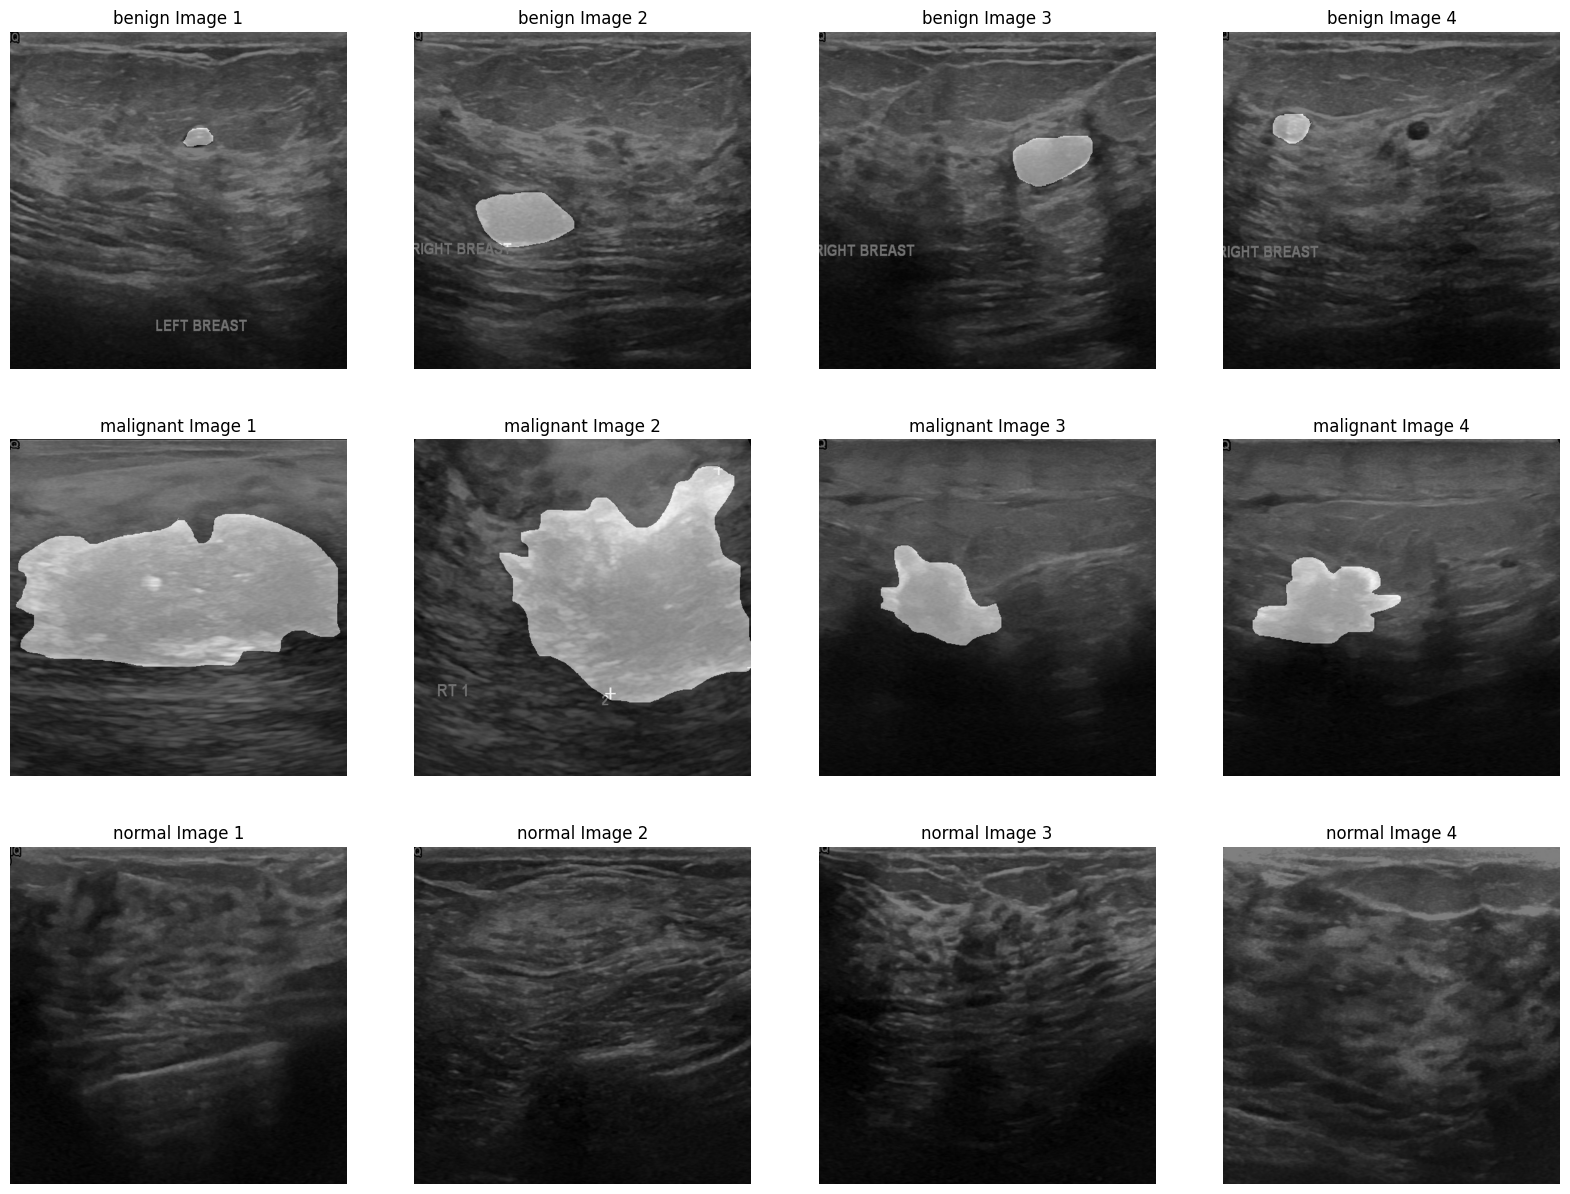

In [18]:
# Set the path to the overlayed images directory
overlayed_dir = '/content/overlayed'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# Desired width and height for each image
desired_width = 800  # Adjust as needed
desired_height = 800  # Adjust as needed

# Loop through each label and display the first 4 images
for i, label_dir in enumerate(label_dirs):
    # Get a list of image files and sort them
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))  # Sort the images by number in parentheses

    for j, image_filename in enumerate(images[:4]):  # Display the first 4 images
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()

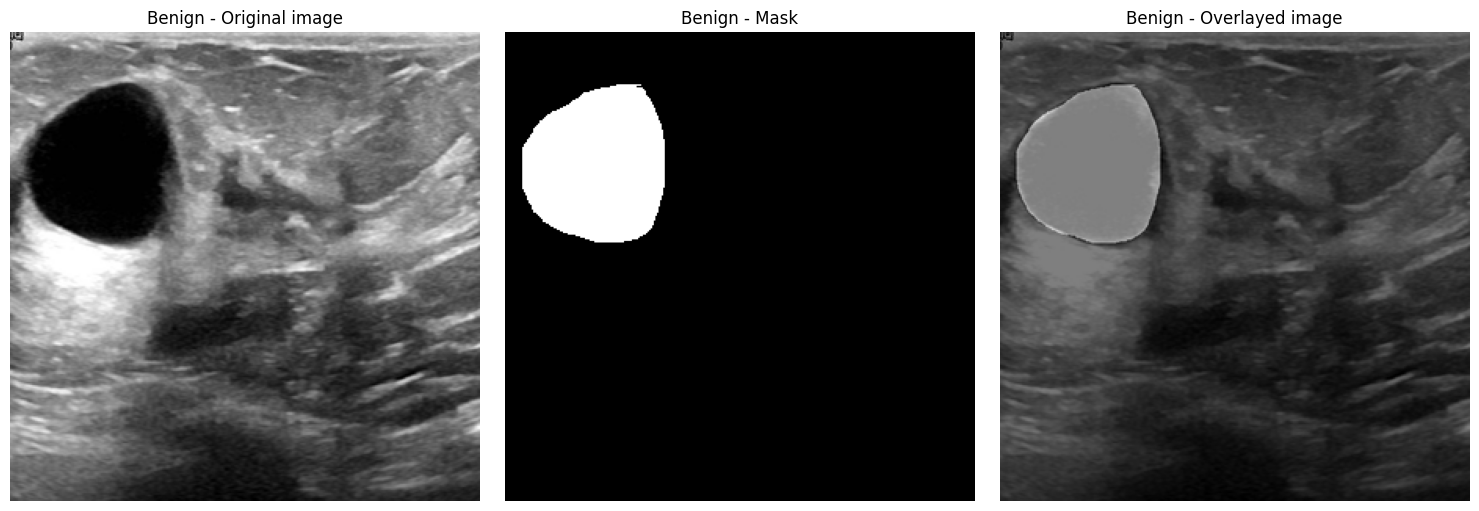

In [19]:
# Define the directory paths
input_dir = '/content/Dataset_BUSI_with_GT'
overlayed_dir = '/content/overlayed/benign'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'benign (10).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('Benign - Original image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Benign - Overlayed image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

## 5.2 - Train / Test split

Application of the function for custom train-test split for each category (benign, malignant, normal).

In [20]:
# Original images - train / test split (splitting 50-50)
custom_split_and_copy(SRC_BENIGN_FOLDER, NO_MASK_BENIGN_TRAIN_FOLDER, NO_MASK_BENIGN_TEST_FOLDER, split_ratio=0.5)
custom_split_and_copy(SRC_MALIGNANT_FOLDER, NO_MASK_MALIGNANT_TRAIN_FOLDER, NO_MASK_MALIGNANT_TEST_FOLDER, split_ratio=0.5)
custom_split_and_copy(SRC_NORMAL_FOLDER, NO_MASK_NORMAL_TRAIN_FOLDER, NO_MASK_NORMAL_TEST_FOLDER, split_ratio=0.5)

# Overlayed images - train / test split (splitting 50-50)
custom_split_and_copy(OVERLAYED_BENIGN_FOLDER, WITH_MASK_BENIGN_TRAIN_FOLDER, WITH_MASK_BENIGN_TEST_FOLDER, split_ratio=0.5)
custom_split_and_copy(OVERLAYED_MALIGNANT_FOLDER, WITH_MASK_MALIGNANT_TRAIN_FOLDER, WITH_MASK_MALIGNANT_TEST_FOLDER, split_ratio=0.5)
custom_split_and_copy(OVERLAYED_NORMAL_FOLDER, WITH_MASK_NORMAL_TRAIN_FOLDER, WITH_MASK_NORMAL_TEST_FOLDER, split_ratio=0.5)

In [21]:
# Original no_mask train / test
no_mask_benign_train_files = os.listdir("/content/no_mask/train/benign")
no_mask_malignant_train_files = os.listdir("/content/no_mask/train/malignant")
no_mask_normal_train_files = os.listdir("/content/no_mask/train/normal")

no_mask_benign_test_files = os.listdir("/content/no_mask/test/benign")
no_mask_malignant_test_files = os.listdir("/content/no_mask/test/malignant")
no_mask_normal_test_files = os.listdir("/content/no_mask/test/normal")

# Overlayed no_mask train / test
with_mask_benign_train_files = os.listdir("/content/with_mask/train/benign")
with_mask_malignant_train_files = os.listdir("/content/with_mask/train/malignant")
with_mask_normal_train_files = os.listdir("/content/with_mask/train/normal")

with_mask_benign_test_files = os.listdir("/content/with_mask/test/benign")
with_mask_malignant_test_files = os.listdir("/content/with_mask/test/malignant")
with_mask_normal_test_files = os.listdir("/content/with_mask/test/normal")

In [22]:
# No_mask
# Benign - count original files  (no_mask)
print(f'In the "no_mask_benign_train_files" folder, there are: {len(no_mask_benign_train_files)} images')
print(f'In the  "no_mask_benign_test_files" folder, there are: {len(no_mask_benign_test_files)} images')
# Malignant - count original files  (no_mask)
print(f'In the  "no_mask_malignant_train_files" folder, there are: {len(no_mask_malignant_train_files)} images')
print(f'In the  "no_mask_malignant_test_files" folder, there are: {len(no_mask_malignant_test_files)} images')
# Normal - count original files  (no_mask)
print(f'In the  "no_mask_normal_train_files" folder, there are: {len(no_mask_normal_train_files)} images')
print(f'In the  "no_mask_normal_test_files" folder, there are: {len(no_mask_normal_test_files)} images')

print('\n')

# With_mask (overlayed)
# Benign - count overlayed files
print(f'In the  "with_mask_benign_train_files" folder, there are: {len(with_mask_benign_train_files)} images')
print(f'In the  "with_mask_benign_test_files" folder, there are: {len(with_mask_benign_test_files)} images')
# Malignant - count overlayed files
print(f'In the  "with_mask_malignant_train_files" folder, there are: {len(with_mask_malignant_train_files)} images')
print(f'In the  "with_mask_malignant_test_files" folder, there are: {len(with_mask_malignant_test_files)} images')
# Normal - count overlayed files
print(f'In the  "with_mask_normal_train_files" folder, there are: {len(with_mask_normal_train_files)} images')
print(f'In the  "with_mask_normal_test_files" folder, there are: {len(with_mask_normal_test_files)} images')

In the "no_mask_benign_train_files" folder, there are: 218 images
In the  "no_mask_benign_test_files" folder, there are: 219 images
In the  "no_mask_malignant_train_files" folder, there are: 105 images
In the  "no_mask_malignant_test_files" folder, there are: 105 images
In the  "no_mask_normal_train_files" folder, there are: 66 images
In the  "no_mask_normal_test_files" folder, there are: 67 images


In the  "with_mask_benign_train_files" folder, there are: 218 images
In the  "with_mask_benign_test_files" folder, there are: 219 images
In the  "with_mask_malignant_train_files" folder, there are: 105 images
In the  "with_mask_malignant_test_files" folder, there are: 105 images
In the  "with_mask_normal_train_files" folder, there are: 66 images
In the  "with_mask_normal_test_files" folder, there are: 67 images


## 5.3 - Datasets creation

In [28]:
# Create datasets with original images
train_set_no_mask = image_dataset_from_directory("no_mask/train", image_size=(180, 180), batch_size=32, label_mode='categorical', labels='inferred', validation_split=0.2, subset="training", seed=common_seed)
val_set_no_mask = image_dataset_from_directory("no_mask/train", image_size=(180, 180), batch_size=32, label_mode='categorical', labels='inferred', validation_split=0.2, subset="validation", seed=common_seed)
test_set_no_mask = image_dataset_from_directory("no_mask/test", image_size=(180, 180), batch_size=32, label_mode='categorical', labels='inferred', seed=common_seed)

# Create datasets with overlayed images
train_set_with_mask = image_dataset_from_directory("with_mask/train", image_size=(180, 180), batch_size=32, label_mode='categorical', validation_split=0.2, subset="training", seed=common_seed)
val_set_with_mask = image_dataset_from_directory("with_mask/train", image_size=(180, 180), batch_size=32, label_mode='categorical', validation_split=0.2, subset="validation", seed=common_seed)
test_set_with_mask = image_dataset_from_directory("with_mask/test", image_size=(180, 180), batch_size=32, label_mode='categorical', seed=common_seed)

Found 389 files belonging to 3 classes.
Using 312 files for training.
Found 389 files belonging to 3 classes.
Using 77 files for validation.
Found 391 files belonging to 3 classes.
Found 389 files belonging to 3 classes.
Using 312 files for training.
Found 389 files belonging to 3 classes.
Using 77 files for validation.
Found 391 files belonging to 3 classes.


## 5.4 - Data Augmentation

In [29]:
# We'll use Albumentation for Data Augmentation
!pip install albumentations

In [30]:
# Creation Augmented Model
data_augmentation = Sequential(
    [
        Input(shape=(180, 180)),
        RandomFlip('horizontal', seed=common_seed),
        RandomRotation(0.1, seed=common_seed),
        RandomZoom(0.1, seed=common_seed),
        # RandomContrast(0.1, seed=common_seed),
        # RandomBrightness(0.1, seed=common_seed),
        # RandomCrop(180,180, seed=common_seed)
    ]
)

## 5.5 - Download pre-trained models for Transfer Learning

In [31]:
# Download VGG16 model (no re-training)
vgg16_net = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(180, 180, 3))
vgg16_net.trainable = False

In [32]:
# Download ResNet101 model (no re-training)
ResNet101_net = ResNet101(include_top=False, weights='imagenet', input_shape=(180, 180, 3))
ResNet101_net.trainable = False

# 6 - Modelling

## 6.1 - Transfer Learning original

### 6.1.1 - Augmentation

In [33]:
# The augmentation is done within the dataset and not by the model
augmented_dataset_original = test_set_no_mask.map(lambda x, y: (data_augmentation(x), y))

In [34]:
x_batch, y_batch = next(iter(train_set_no_mask))

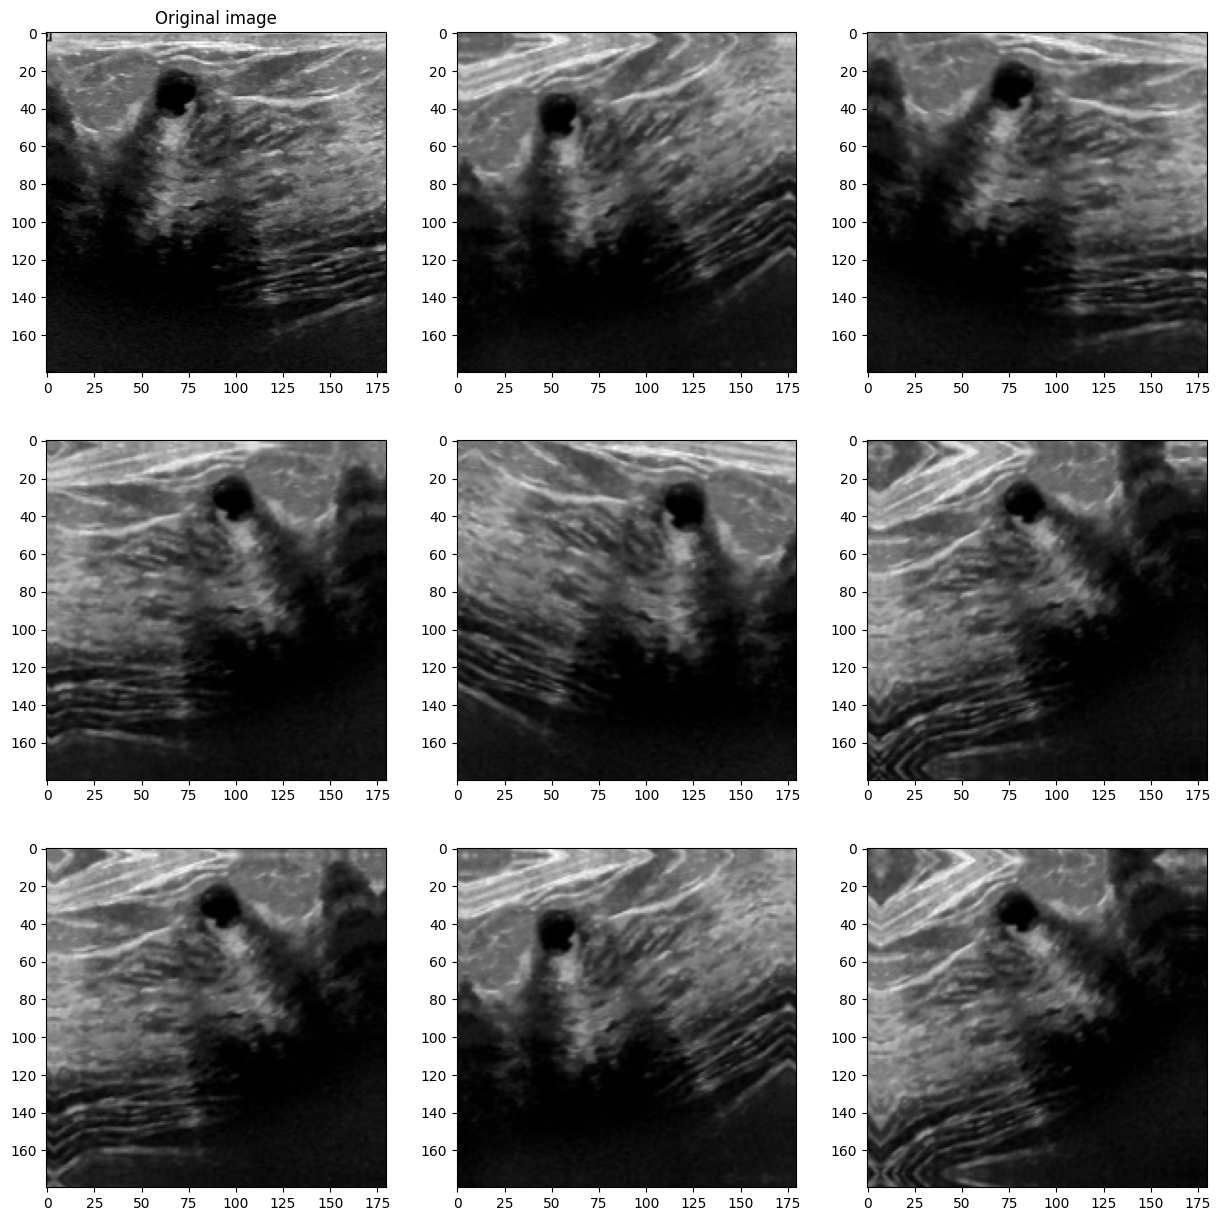

In [35]:
show_augmetation_results(3, 3, x_batch[1]/255)

### 6.1.2 - VGG16: Model creation and compilation, Setting Callbacks

In [48]:
# Create the model with data augmentation
vgg16_augmentation_original = Sequential([
    Input(shape=(180, 180, 3)),
    data_augmentation,
    Lambda(preprocess_input),
    vgg16_net,
    Flatten(),
    Dense(256, 'relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
vgg16_augmentation_original.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting Callbacks
csv_logger_vgg16_augmentation_original = CSVLogger('logger_vgg16_augmentation_original.csv')
checkpoint_vgg16_augmentation_original = ModelCheckpoint('checkpoint_vgg16_augmentation_original')
early_stopping_vgg16_augmentation_original = EarlyStopping(patience=10, restore_best_weights=True)

In [49]:
vgg16_augmentation_original.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180)          0         
                                                                 
 lambda_2 (Lambda)           (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                

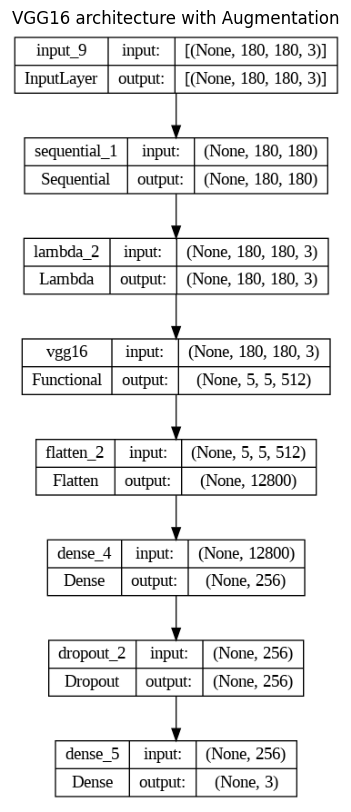

In [50]:
plot_model(model=vgg16_augmentation_original, show_shapes=True, to_file='model_1.png')

image = plt.imread('model_1.png')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title('VGG16 architecture with Augmentation')
plt.axis('off')
plt.savefig('model_1_VGG16.png')
plt.show()

#### 6.1.2.1 - Model training

In [51]:
vgg16_augmentation_original.fit(
    x=train_set_no_mask,
    epochs=100,
    validation_data=val_set_no_mask,
    callbacks=[csv_logger_vgg16_augmentation_original, checkpoint_vgg16_augmentation_original, early_stopping_vgg16_augmentation_original]
)

Epoch 1/100
10/10 [==============================] - 11s 624ms/step - loss: 9.8729 - accuracy: 0.5000 - val_loss: 2.4428 - val_accuracy: 0.6753
Epoch 2/100
10/10 [==============================] - 7s 560ms/step - loss: 3.6688 - accuracy: 0.6859 - val_loss: 3.0452 - val_accuracy: 0.7143
Epoch 3/100
10/10 [==============================] - 7s 569ms/step - loss: 1.9575 - accuracy: 0.7949 - val_loss: 1.4931 - val_accuracy: 0.6753
Epoch 4/100
10/10 [==============================] - 10s 810ms/step - loss: 1.3180 - accuracy: 0.7853 - val_loss: 0.8023 - val_accuracy: 0.7532
Epoch 5/100
10/10 [==============================] - 9s 673ms/step - loss: 0.7583 - accuracy: 0.7788 - val_loss: 0.7248 - val_accuracy: 0.7013
Epoch 6/100
10/10 [==============================] - 7s 507ms/step - loss: 0.5613 - accuracy: 0.8077 - val_loss: 0.7885 - val_accuracy: 0.7013
Epoch 7/100
10/10 [==============================] - 7s 571ms/step - loss: 0.5442 - accuracy: 0.8109 - val_loss: 0.7650 - val_accuracy: 0.66

In [52]:
# Dictionary containing training history: it has various keys, in this case, there are 4: loss, accuracy, val_loss, val_accuracy
h = vgg16_augmentation_original.history.history

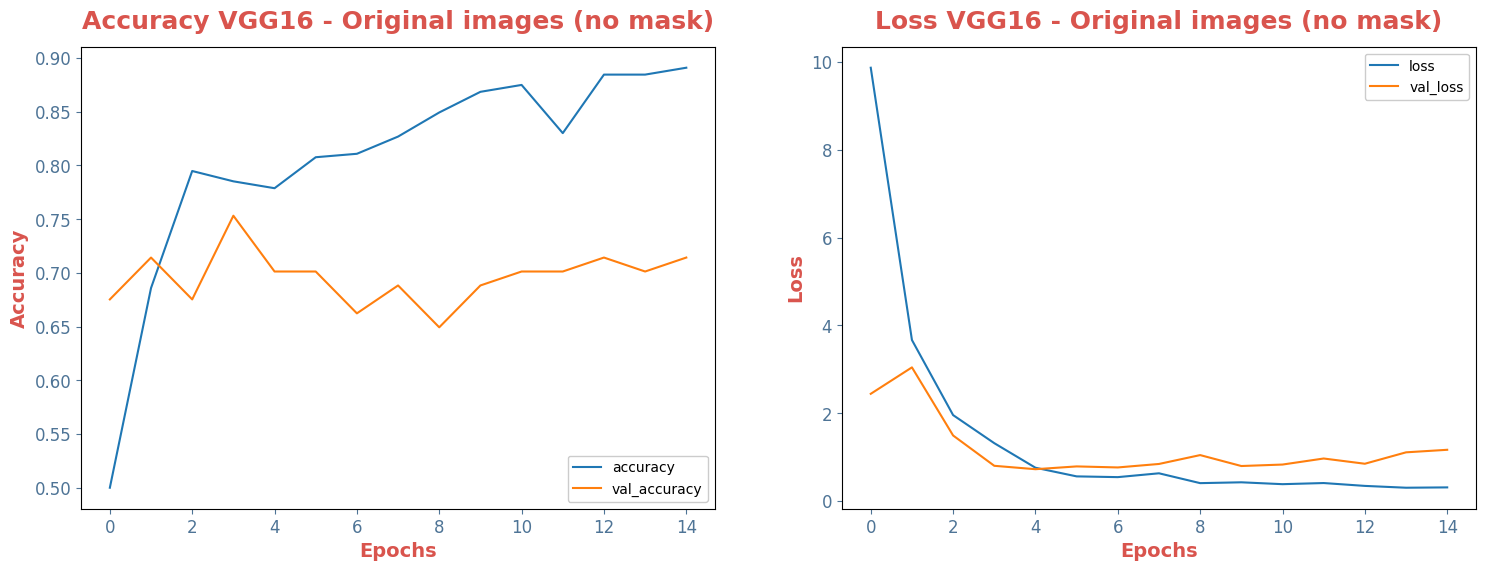

In [53]:
loss = h['loss']
val_loss = h['val_loss']
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].legend()
ax[0].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1, loc='lower right')
nice_plotting(ax[0], title='Accuracy VGG16 - Original images (no mask)', xlabel='Epochs', ylabel='Accuracy', new_fig=False, figsize=(10, 6))

ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].legend()
ax[1].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1)
nice_plotting(ax[1], title='Loss VGG16 - Original images (no mask)', xlabel='Epochs', ylabel='Loss', new_fig=False, figsize=(10, 6))

plt.savefig('Train_VGG16_Real_Images.png')
plt.show()

#### 6.1.2.2 - Model evaluation

In [54]:
vgg16_augmentation_original.evaluate(x=test_set_no_mask)

13/13 [==============================] - 3s 106ms/step - loss: 0.9747 - accuracy: 0.6880


[0.9747433662414551, 0.687979519367218]

#### 6.1.2.3 - Confusion matrix

In [55]:
# Obtain real and predicted labels of test set with mask
true_labels, predicted_labels = get_true_and_predicted_labels(vgg16_augmentation_original, test_set_no_mask)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

1/1 [==============================] - 0s 236ms/step


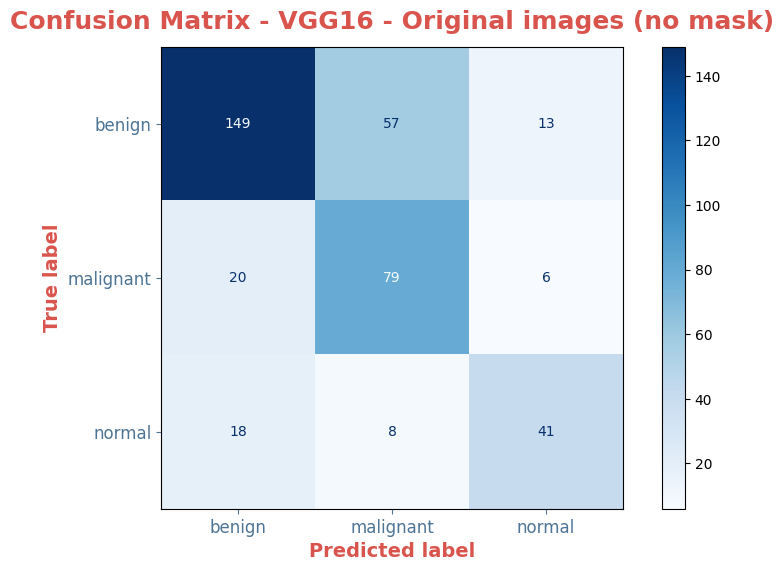

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "malignant", "normal"])

fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.set_title("Confusion Matrix - VGG16 - Original images (no mask)", color='xkcd:pale red', fontsize=18, pad=13, fontweight='bold')
ax.set_xlabel("Predicted label", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.set_ylabel("True label", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

plt.savefig('Confusion_Matrix_VGG16_Real_Images.png')
plt.show()

In [57]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
class_report = classification_report(true_labels, predicted_labels, target_names=["benign", "malignant", "normal"])
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')
class_report_with_f2 = f"{class_report}\n\nF2-Score: {f2_score}"

print("\033[1m\033[91mClassification Report - VGG16 - Original images (no mask):\033[0m\033[0m")
print(class_report_with_f2)

Classification Report - VGG16 - Original images (no mask):
              precision    recall  f1-score   support

      benign       0.80      0.68      0.73       219
   malignant       0.55      0.75      0.63       105
      normal       0.68      0.61      0.65        67

    accuracy                           0.69       391
   macro avg       0.68      0.68      0.67       391
weighted avg       0.71      0.69      0.69       391


F2-Score: 0.6877177817623579


### 6.1.3 - ResNet101: Model creation and compilation, Setting Callbacks

In [47]:
# Create the model with data augmentation
ResNet101_augmentation_original = Sequential([
    Input(shape=(180, 180, 3)),
    data_augmentation,
    Lambda(preprocess_input),
    ResNet101_net,
    Flatten(),
    Dense(256, 'relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
ResNet101_augmentation_original.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting Callbacks
csv_logger_ResNet101_augmentation_original = CSVLogger('logger_resnet101_augmentation_original.csv')
checkpoint_ResNet101_augmentation_original = ModelCheckpoint('checkpoint_resnet101_augmentation_original')
early_stopping_ResNet101_augmentation_original = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
ResNet101_augmentation_original.summary()

In [ ]:
plot_model(model=ResNet101_augmentation_original, show_shapes=True, to_file='model_2.png')

image = plt.imread('model_2.png')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title('ResNet101 architecture with Augmentation')
plt.axis('off')
plt.savefig('model_2_ResNet101.png')
plt.show()

#### 6.1.3.1 - Model training

In [ ]:
ResNet101_augmentation_original.fit(
    x=train_set_no_mask,
    epochs=100,
    validation_data=val_set_no_mask,
    callbacks=[csv_logger_ResNet101_augmentation_original, checkpoint_ResNet101_augmentation_original, early_stopping_ResNet101_augmentation_original]
)

Epoch 1/100
10/10 [==============================] - 55s 5s/step - loss: 33.6800 - accuracy: 0.5000 - val_loss: 13.7259 - val_accuracy: 0.6506
Epoch 2/100
10/10 [==============================] - 42s 4s/step - loss: 12.2562 - accuracy: 0.6154 - val_loss: 2.4521 - val_accuracy: 0.8141
Epoch 3/100
10/10 [==============================] - 42s 5s/step - loss: 4.8147 - accuracy: 0.6891 - val_loss: 1.6534 - val_accuracy: 0.7468
Epoch 4/100
10/10 [==============================] - 42s 4s/step - loss: 1.6598 - accuracy: 0.7308 - val_loss: 0.4175 - val_accuracy: 0.8654
Epoch 5/100
10/10 [==============================] - 42s 5s/step - loss: 0.7410 - accuracy: 0.7404 - val_loss: 0.5264 - val_accuracy: 0.8045
Epoch 6/100
10/10 [==============================] - 42s 4s/step - loss: 0.6487 - accuracy: 0.7244 - val_loss: 0.5701 - val_accuracy: 0.8013
Epoch 7/100
10/10 [==============================] - 42s 5s/step - loss: 0.6619 - accuracy: 0.7115 - val_loss: 0.4417 - val_accuracy: 0.8526
Epoch 8/10

In [ ]:
# Dictionary containing training history: it has various keys, in this case, there are 4: loss, accuracy, val_loss, val_accuracy
h = ResNet101_augmentation_original.history.history

In [ ]:
loss = h['loss']
val_loss = h['val_loss']
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].legend()
ax[0].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1, loc='lower right')
nice_plotting(ax[0], title='Accuracy ResNet101 - Original images (no mask)', xlabel='Epochs', ylabel='Accuracy', new_fig=False, figsize=(10, 6))

ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].legend()
ax[1].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1)
nice_plotting(ax[1], title='Loss ResNet101 - Original images (no mask)', xlabel='Epochs', ylabel='Loss', new_fig=False, figsize=(10, 6))

plt.savefig('Train_ResNet101_Real_Images.png')
plt.show()

#### 6.1.3.2 - Model evaluation

In [ ]:
ResNet101_augmentation_original.evaluate(x=test_set_no_mask)

#### 6.1.3.3 - Confusion matrix

In [ ]:
# Obtain real and predicted labels of test set with mask
true_labels, predicted_labels = get_true_and_predicted_labels(ResNet101_augmentation_original, test_set_no_mask)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "malignant", "normal"])

fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(cmap='Greens', values_format='d', ax=ax)
ax.set_title("Confusion Matrix - ResNet101 - Original images (no mask)", color='xkcd:pale red', fontsize=18, pad=13, fontweight='bold')
ax.set_xlabel("Predicted label", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.set_ylabel("True label", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

plt.savefig('Confusion_Matrix_ResNet101_Real_Images.png')
plt.show()

In [ ]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
class_report = classification_report(true_labels, predicted_labels, target_names=["benign", "malignant", "normal"])
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')
class_report_with_f2 = f"{class_report}\n\nF2-Score: {f2_score}"

print("\033[1m\033[91mClassification Report - ResNet101 - Original images (no mask):\033[0m\033[0m")
print(class_report_with_f2)

## 6.2 - Transfer Learning overlayed

### 6.2.1 - Augmentation

In [ ]:
# The augmentation is done within the dataset and not by the model
augmented_dataset_overlayed = test_set_with_mask.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
x_batch, y_batch = next(iter(train_set_with_mask))

In [ ]:
show_augmetation_results(3, 3, x_batch[2]/255)

### 6.2.2 - VGG16: Model creation and compilation, Setting Callbacks

In [ ]:
# Create the model with data augmentation
vgg16_augmentation_overlayed = Sequential([
    Input(shape=(180, 180, 3)),
    data_augmentation,
    Lambda(preprocess_input),
    vgg16_net,
    Flatten(),
    Dense(256, 'relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
vgg16_augmentation_overlayed.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting Callbacks
csv_logger_vgg16_augmentation_overlayed = CSVLogger('logger_vgg16_augmentation_overlayed.csv')
checkpoint_vgg16_augmentation_overlayed = ModelCheckpoint('checkpoint_vgg16_augmentation_overlayed')
early_stopping_vgg16_augmentation_overlayed = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
vgg16_augmentation_overlayed.summary()

#### 6.2.2.1 - Model training

In [ ]:
vgg16_augmentation_overlayed.fit(
    x=train_set_with_mask,
    epochs=100,
    validation_data=val_set_with_mask,
    callbacks=[csv_logger_vgg16_augmentation_overlayed, checkpoint_vgg16_augmentation_overlayed, early_stopping_vgg16_augmentation_overlayed]
)

In [ ]:
# Dictionary containing training history: it has various keys, in this case, there are 4: loss, accuracy, val_loss, val_accuracy
h = vgg16_augmentation_overlayed.history.history

In [ ]:
loss = h['loss']
val_loss = h['val_loss']
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].legend()
ax[0].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1, loc='lower right')
nice_plotting(ax[0], title='Accuracy VGG16 - Overlayed images', xlabel='Epochs', ylabel='Accuracy', new_fig=False, figsize=(10, 6))

ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].legend()
ax[1].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1)
nice_plotting(ax[1], title='Loss VGG16 - Overlayed images', xlabel='Epochs', ylabel='Loss', new_fig=False, figsize=(10, 6))

plt.savefig('Train_VGG16_Overalyed_Images.png')
plt.show()

#### 6.2.2.2 - Model evaluation

In [ ]:
vgg16_augmentation_overlayed.evaluate(x=test_set_with_mask)

#### 6.2.2.3 - Confusion matrix

In [ ]:
# Obtain real and predicted labels of test set with mask
true_labels, predicted_labels = get_true_and_predicted_labels(vgg16_augmentation_overlayed, test_set_with_mask)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "malignant", "normal"])

fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(cmap='OrRd', values_format='d', ax=ax)
ax.set_title("Confusion Matrix - VGG16 - Overlayed images", color='xkcd:pale red', fontsize=18, pad=13, fontweight='bold')
ax.set_xlabel("Predicted label", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.set_ylabel("True label", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

plt.savefig('Confusion_Matrix_VGG16_Overlayed_Images.png')
plt.show()

In [ ]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
class_report = classification_report(true_labels, predicted_labels, target_names=["benign", "malignant", "normal"])
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')
class_report_with_f2 = f"{class_report}\n\nF2-Score: {f2_score}"

print("\033[1m\033[91mClassification Report - VGG16 - Overlayed images:\033[0m\033[0m")
print(class_report_with_f2)

### 6.2.3 - ResNet101: Model creation and compilation, Setting Callbacks

In [ ]:
# Create the model with data augmentation
ResNet101_augmentation_overlayed = Sequential([
    Input(shape=(180, 180, 3)),
    data_augmentation,
    Lambda(preprocess_input),
    ResNet101_net,
    Flatten(),
    Dense(256, 'relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
ResNet101_augmentation_overlayed.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting Callbacks
csv_logger_ResNet101_augmentation_overlayed = CSVLogger('logger_resnet101_augmentation_overlayed.csv')
checkpoint_ResNet101_augmentation_overlayed = ModelCheckpoint('checkpoint_resnet101_augmentation_overlayed')
early_stopping_ResNet101_augmentation_overlayed = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
ResNet101_augmentation_overlayed.summary()

#### 6.2.3.1 - Model training

In [ ]:
ResNet101_augmentation_overlayed.fit(
    x=train_set_with_mask,
    epochs=100,
    validation_data=val_set_with_mask,
    callbacks=[csv_logger_ResNet101_augmentation_overlayed, checkpoint_ResNet101_augmentation_overlayed, early_stopping_ResNet101_augmentation_overlayed]
)

In [ ]:
# Dictionary containing training history: it has various keys, in this case, there are 4: loss, accuracy, val_loss, val_accuracy
h = ResNet101_augmentation_overlayed.history.history

In [ ]:
loss = h['loss']
val_loss = h['val_loss']
accuracy = h['accuracy']
val_accuracy = h['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].legend()
ax[0].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1, loc='lower right')
nice_plotting(ax[0], title='Accuracy ResNet101 - Overlayed images', xlabel='Epochs', ylabel='Accuracy', new_fig=False, figsize=(10, 6))

ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].legend()
ax[1].legend(frameon=True, fancybox=True, facecolor='white', framealpha=1)
nice_plotting(ax[1], title='Loss ResNet101 - Overlayed images', xlabel='Epochs', ylabel='Loss', new_fig=False, figsize=(10, 6))

plt.savefig('Train_ResNet101_Overlayed_Images.png')
plt.show()

#### 6.2.3.2 - Model evaluation

In [ ]:
ResNet101_augmentation_overlayed.evaluate(x=test_set_with_mask)

#### 6.2.3.3 - Confusion matrix

In [ ]:
# Obtain real and predicted labels of test set with mask
true_labels, predicted_labels = get_true_and_predicted_labels(ResNet101_augmentation_overlayed, test_set_with_mask)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "malignant", "normal"])

fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(cmap='Purples', values_format='d', ax=ax)
ax.set_title("Confusion Matrix - ResNet101 - Overlayed images", color='xkcd:pale red', fontsize=18, pad=13, fontweight='bold')
ax.set_xlabel("Predicted label", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.set_ylabel("True label", color='xkcd:pale red', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, colors='xkcd:cadet blue')
ax.tick_params(axis='y', labelsize=12, colors='xkcd:cadet blue')

plt.savefig('Confusion_Matrix_ResNet101_Overlayed_Images.png')
plt.show()

In [ ]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
class_report = classification_report(true_labels, predicted_labels, target_names=["benign", "malignant", "normal"])
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')
class_report_with_f2 = f"{class_report}\n\nF2-Score: {f2_score}"

print("\033[1m\033[91mClassification Report - ResNet101 - Overlayed images:\033[0m\033[0m")
print(class_report_with_f2)